# Test Lion optimizer on MNIST

In this notebook, we will test the Lion optimizer on the MNIST dataset.

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from src.lion.lion import Lion

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [3]:
class Model(nn.Module):
    def __init__(self, num_classes: int):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 3 * 3, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
from torch.optim import Adam

batch_size = 32
epochs = 10
model_1 = Model(num_classes=10).to(device)
model_2 = Model(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_1 = Lion(model_1.parameters(), lr=0.0001)
optimizer_2 = Adam(model_2.parameters(), lr=0.0001)

In [5]:
import matplotlib.pyplot as plt


def train_model(model, optimizer, train_loader, test_loader, criterion, epochs):
    model.train()

    train_losses = []
    test_losses = []

    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
        
        model.train()
    
    return train_losses, test_losses, train_accuracies, test_accuracies


In [6]:
print("Lion")
train_losses_1, test_losses_1, train_accuracies_1, test_accuracies_1 = train_model(model_1, optimizer_1, train_loader, test_loader, criterion, epochs)
print("\nAdam")
train_losses_2, test_losses_2, train_accuracies_2, test_accuracies_2 = train_model(model_2, optimizer_2, train_loader, test_loader, criterion, epochs)

Lion
Epoch [1/10], Train Loss: 1.4227, Train Accuracy: 52.38%, Test Loss: 0.3909, Test Accuracy: 88.85%
Epoch [2/10], Train Loss: 0.3994, Train Accuracy: 87.68%, Test Loss: 0.1424, Test Accuracy: 95.49%
Epoch [3/10], Train Loss: 0.2320, Train Accuracy: 92.92%, Test Loss: 0.0799, Test Accuracy: 97.41%
Epoch [4/10], Train Loss: 0.1678, Train Accuracy: 94.92%, Test Loss: 0.0613, Test Accuracy: 98.06%
Epoch [5/10], Train Loss: 0.1335, Train Accuracy: 96.02%, Test Loss: 0.0522, Test Accuracy: 98.30%
Epoch [6/10], Train Loss: 0.1124, Train Accuracy: 96.71%, Test Loss: 0.0419, Test Accuracy: 98.67%
Epoch [7/10], Train Loss: 0.0974, Train Accuracy: 97.11%, Test Loss: 0.0390, Test Accuracy: 98.81%
Epoch [8/10], Train Loss: 0.0862, Train Accuracy: 97.37%, Test Loss: 0.0366, Test Accuracy: 98.84%
Epoch [9/10], Train Loss: 0.0825, Train Accuracy: 97.56%, Test Loss: 0.0322, Test Accuracy: 99.01%
Epoch [10/10], Train Loss: 0.0740, Train Accuracy: 97.74%, Test Loss: 0.0325, Test Accuracy: 99.00%

Ada

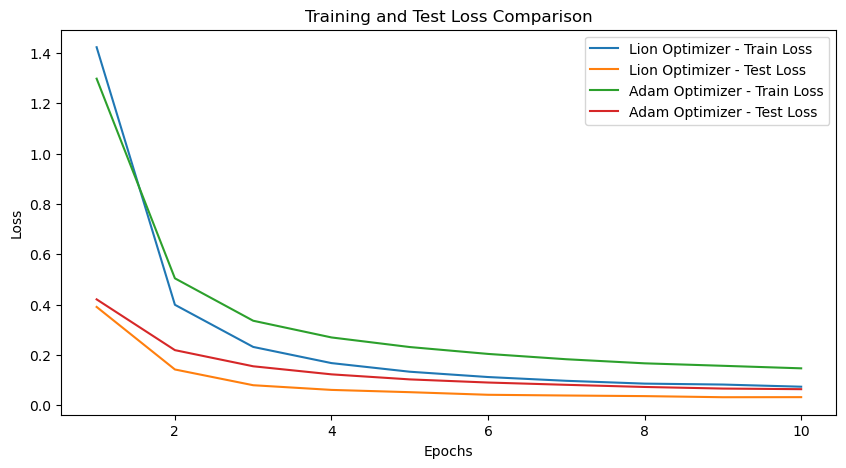

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses_1, label='Lion Optimizer - Train Loss')
plt.plot(range(1, epochs + 1), test_losses_1, label='Lion Optimizer - Test Loss')
plt.plot(range(1, epochs + 1), train_losses_2, label='Adam Optimizer - Train Loss')
plt.plot(range(1, epochs + 1), test_losses_2, label='Adam Optimizer - Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Comparison')
plt.legend()
plt.show()

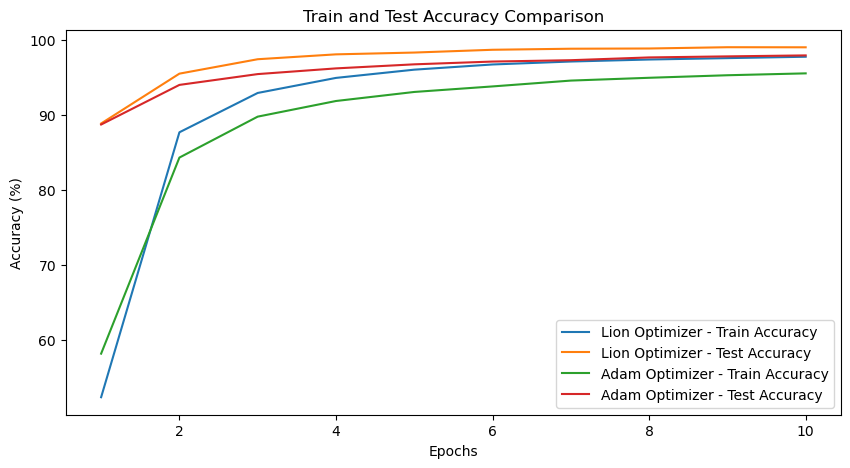

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies_1, label='Lion Optimizer - Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies_1, label='Lion Optimizer - Test Accuracy')
plt.plot(range(1, epochs + 1), train_accuracies_2, label='Adam Optimizer - Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies_2, label='Adam Optimizer - Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy Comparison')
plt.legend()
plt.show()